# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar


!pwd!!!!For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [3]:
%cd /content/drive/MyDrive/NN

!pwd

/content/drive/MyDrive/NN
/content/drive/MyDrive/NN


In [4]:
!pwd

/content/drive/MyDrive/NN


In [ ]:
!pip install scipy==1.1.0

### 1.1 Loading the dataset

In [6]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms


class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.vgg import VGG

from matplotlib import pyplot as plt
import numpy as np
import time
import sys
import os




ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}


cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}



class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)
class FCNs(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)



class VGGNet(VGG):

    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}
        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output 

######################outside the class #####

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)



class Segnet(nn.Module):


  
  def __init__(self, pretrained_net, n_class ):
    super(Segnet, self).__init__()
    #define the layers for your model
    self.n_class = n_class
    self.pretrained_net = pretrained_net
    self.relu    = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn1     = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn2     = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn3     = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn4     = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn5     = nn.BatchNorm2d(32)
    self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

  def forward(self, x):
    #define the forward pass
    output = self.pretrained_net(x)
    x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
    x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
    x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
    x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
    x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

    score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
    score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
    score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
    score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
    score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
    score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
    score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
    score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
    score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
    score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

    return score  # size=(N, n_class, x.H/1, x.W/1)    


In [8]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
# you can also modify the models as we have defined FCN 16, FCN 8 and check how different models work
vgg_model = VGGNet(requires_grad=True)
n_class=21
model = Segnet(vgg_model, 21)
model.load_state_dict(torch.load("/content/drive/MyDrive/NN/model.pth"))
model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Segnet(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [10]:
local_path = '/content/drive/MyDrive/NN/VOCdevkit/VOC2012/' # modify it according to your device
bs = 8
epochs = 25
lr = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
n_class    = 21


### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [11]:
from torch.utils.data import DataLoader

# dataset variable
train_dst = pascalVOCDataset(local_path, split='train', is_transform=True)
val_dst = pascalVOCDataset(local_path, split='val', is_transform=True)

# dataloader variable
trainloader = DataLoader(train_dst, batch_size=bs, shuffle=True)
valloader = DataLoader(val_dst, batch_size=bs, shuffle=False)

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [12]:
# loss function :- using cross entropy as a loss function
loss_f = nn.CrossEntropyLoss()

# optimizer variable :- using adam optimizer.
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=w_decay)


### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [11]:
for epoch in range(epochs):
  
  ts = time.time()
  count=0
  for i, d in enumerate(trainloader):
    # your code goes here
    opt.zero_grad()
    inputs = Variable(d[0].cuda())
    labels = Variable(d[1].cuda())    
    outputs = model(inputs)
    loss = loss_f(outputs, labels)
    loss.backward()
    opt.step()
   
    if i % 10 == 0:
            print("epoch{}, i{}, loss: {}".format(epoch, i, loss.data))

  torch.save(model.state_dict(), "model.pth")
   




epoch0, i0, loss: 0.1493898630142212
epoch0, i10, loss: 0.13895070552825928
epoch0, i20, loss: 0.166533961892128
epoch0, i30, loss: 0.12248534709215164
epoch0, i40, loss: 0.1633681356906891
epoch0, i50, loss: 0.11906878650188446
epoch0, i60, loss: 0.22292093932628632
epoch0, i70, loss: 0.2774786353111267
epoch0, i80, loss: 0.2617059648036957
epoch0, i90, loss: 0.1872100681066513
epoch0, i100, loss: 0.16589681804180145
epoch0, i110, loss: 0.5350216627120972
epoch0, i120, loss: 0.27228912711143494
epoch0, i130, loss: 0.24530577659606934
epoch0, i140, loss: 0.18659885227680206
epoch0, i150, loss: 0.19773757457733154
epoch0, i160, loss: 0.08820304274559021
epoch0, i170, loss: 0.1922241747379303
epoch0, i180, loss: 0.17512823641300201
epoch0, i190, loss: 0.13649225234985352
epoch0, i200, loss: 0.32108190655708313
epoch0, i210, loss: 0.3189948499202728
epoch0, i220, loss: 0.23616650700569153
epoch0, i230, loss: 0.1239880695939064
epoch0, i240, loss: 0.13894441723823547
epoch0, i250, loss: 0.

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import jaccard_score



def evaluate(ground_truth,predictions ):
  
  ground_truth = ground_truth.reshape(-1)
  predictions = predictions.reshape(-1)
  gtprob= ground_truth
  f1=f1_score(ground_truth, predictions, labels=list(range(21)), average='weighted')
  dice_coeficient = jaccard_score(ground_truth,predictions, average = 'weighted')
  #auc_score = roc_auc_score(gtprob,predprob,average = 'weighted',multi_class = 'ovr')
  #roc=roc_auc_score(ground_truth, yhat_probs, multi_class='ovr')

  return f1, dice_coeficient    

model.eval()

F1_Score = []
#AUC_Score = []
Dice_Score = []
Epochs = []
for epoch in range(epochs):
  current_f1 = []
  #current_auc = []
  current_jac = []
  for iter, batch in enumerate(valloader):
      
      inputs = Variable(batch[0].cuda())
      output = model(inputs)
      # print("output size :-  ",output.size)

      pred = output.argmax(axis=1).cpu().detach().numpy()
      #print(torch.unique(batch[1]))
      target = batch[1].cpu().detach().numpy()
      
      f1, dice = evaluate(ground_truth=target,predictions=pred)
      current_f1.append(f1)
      #current_auc.append(auc)
      current_jac.append(dice)
      if iter % 10 == 0:
        print("epoch",epoch," iter :- ", iter,"f1 :- " ,f1,"  dice :--  ",dice)
      
  F1_Score.append(sum(current_f1)/len(current_f1))
  #AUC_Score.append(sum(current_auc)/len(current_auc))
  Dice_Score.append(sum(current_jac)/len(current_jac))
  Epochs.append(epoch)
  
  print("Epochs inside epoch loop:- " ,Epochs)
  print("f1 avg inside epoch loop :- " ,F1_Score,"  dice avg :--  ",Dice_Score)

print("f1 avg :- " ,F1_Score,"  dice avg :--  ",Dice_Score)
print("Epochs :- " ,Epochs)





torch.cuda.empty_cache()


epoch 0  iter :-  0 f1 :-  0.9842916193314007   dice :--   0.9737983461551841


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch 0  iter :-  10 f1 :-  0.9711658168722235   dice :--   0.954849836266513
epoch 0  iter :-  20 f1 :-  0.9746150805477655   dice :--   0.9584482409436894
epoch 0  iter :-  30 f1 :-  0.9858944393221286   dice :--   0.9763424551061598
epoch 0  iter :-  40 f1 :-  0.9763418681283116   dice :--   0.9617942425898178
epoch 0  iter :-  50 f1 :-  0.9842500770642153   dice :--   0.9745574234442386
epoch 0  iter :-  60 f1 :-  0.9799844680041845   dice :--   0.9656105971562073
epoch 0  iter :-  70 f1 :-  0.9755870582093192   dice :--   0.959057970273808
epoch 0  iter :-  80 f1 :-  0.9762119794166897   dice :--   0.9615002375157435
epoch 0  iter :-  90 f1 :-  0.9741024093878632   dice :--   0.957893872749099
epoch 0  iter :-  100 f1 :-  0.9844465012882372   dice :--   0.9737832586171622
epoch 0  iter :-  110 f1 :-  0.9888488458534335   dice :--   0.9806431363782822
epoch 0  iter :-  120 f1 :-  0.9600319267397992   dice :--   0.9334711247432668
epoch 0  iter :-  130 f1 :-  0.9751726917750736   di

In [33]:
torch.cuda.empty_cache()


In [3]:
sam_f1=[0.9756602543894629, 0.9756581383893467, 0.9756292150666245, 0.9756492977366985, 0.9756576794991597, 0.9756851792892927, 0.9757226068891902, 0.9756582024822472, 0.9756828266125992, 0.9756654335825538, 0.9754932973803216, 0.9757306050701466, 0.9756821911567852, 0.9756883026947527, 0.9756664794800018, 0.9756914725407307, 0.9756880863444332, 0.975718380662015, 0.9756664334327607, 0.975672089631372, 0.9757204200879822, 0.9756925896527154, 0.9755917147256303, 0.9756969463741947, 0.9755838358861051]
sam_dice=[0.9604580493591869, 0.9604665517404165, 0.9604543863432828, 0.9604652706441908, 0.9605371052104797, 0.9604959608837069, 0.9605594007251534, 0.9604869565811485, 0.9605308844166891, 0.9604715488787988, 0.9602552397059515, 0.9605582390384898, 0.9605187616571469, 0.9605646372732899, 0.9605129950695942, 0.9605482289897965, 0.9604831187223667, 0.9605171926770627, 0.9605705975202481, 0.9605133344420516, 0.9605659089656502, 0.9605892934143472, 0.9604278142008609, 0.960554910211952, 0.9603823390114116]

totalf1=sum(sam_f1)/len(sam_f1)
totaldice=sum(sam_dice)/len(sam_dice)
print("Model's average F1 score :- ",totalf1)
print("Model's average Dice/Jaccard  score :- ",totaldice)




Model's average F1 score :-  0.9756660671622852
Model's average Dice/Jaccard  score :-  0.9604995490273308


### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

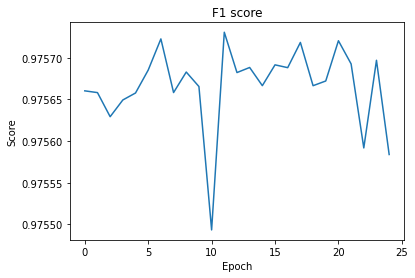

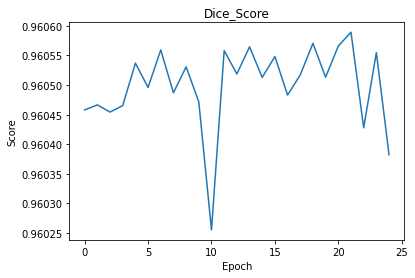

In [14]:
""" The f1 scoe and the jacquard scores were calculated as evaluation metrics for 5 epochs as it is time consuming and memory overloads 
as the epochs increase. the results were f1 avg :-  [0.9491091665709125, 0.9488723057308398, 0.949395109258993, 0.9491168163870759, 0.9492904104235802]
and  jacquard score as dice avg: dice avg :--   [0.9189321611744259, 0.918614833500603, 0.9192535840839914, 0.9189031884617523, 0.9191153086259517]
The evaluation results represents a good outcome of the model      """


plt.title("F1 score")
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.plot(Epochs,F1_Score)
plt.show()

# plt.title("ROC_AUC score")
# plt.xlabel('Epoch')
# plt.ylabel('Score')
# plt.plot(Epochs,AUC_Score)
# plt.show()

plt.title("Dice_Score")
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.plot(Epochs,Dice_Score)
plt.show()









### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


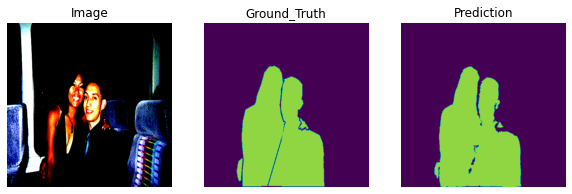

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


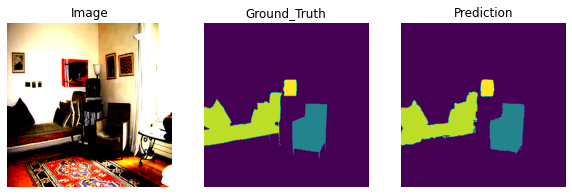

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


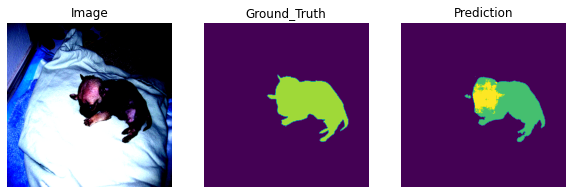

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


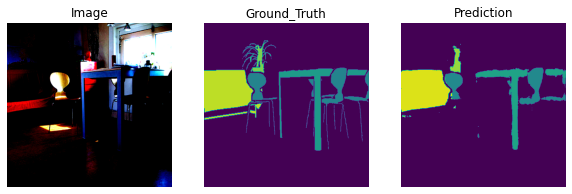

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


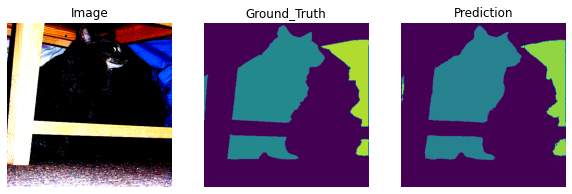

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


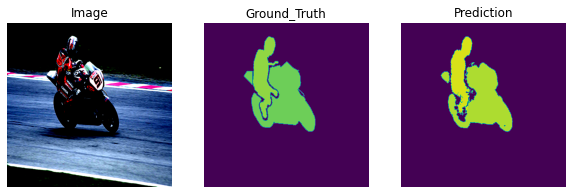

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


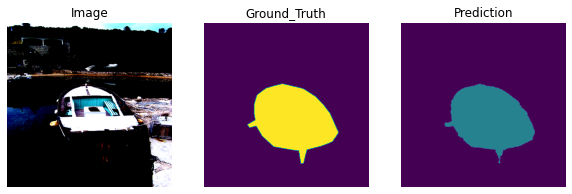

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


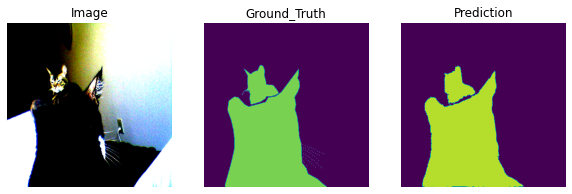

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


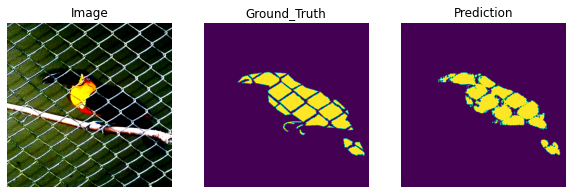

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


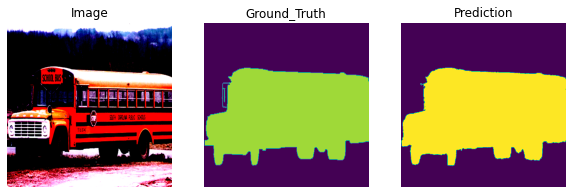

In [15]:

"""Here we have visualized the image with their Ground truth and Predictions our model had
 predicted on training it. It seems that the model can predict the images well although not completely accurate"""  

torch.manual_seed(10)
iterator = enumerate(valloader)
for _ in range(10):
  fig= plt.figure(figsize=(10,10))
  index, (image, mask) = iterator.__next__()
  image= image.cuda()
  mask= mask.cuda().detach().cpu().numpy()
  preds= model(image)
  preds= preds.detach().cpu().numpy()
  image= image.cpu()
  fig1= fig.add_subplot(131)
  plt.imshow(image[0].transpose(0,2).transpose(0,1).numpy())
  fig1.title.set_text("Image")
  fig1.axis("off")
  fig2= fig.add_subplot(132)
  plt.imshow(mask[0])
  fig2.title.set_text("Ground_Truth")
  fig2.axis("off")
  fig3= fig.add_subplot(133)
  plt.imshow(preds.argmax(1)[0])
  fig3.title.set_text("Prediction")
  fig3.axis("off")
  plt.show()